# 011 Network Analysis Result Summary
* Analyze disparities in evacuation behavior before, during, and after Hurricane Harvey
* Summary information for Table 3
* Create FigS5 b and FigS5 c
* Mapping and additional analysis have been done in Quantum GIS version 3.4 Madeira

In [1]:
import pandas as pd
import numpy as np
from math import sin, cos, sqrt, atan2, radians, pi
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Check package versions
import types 
def imports():
    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            yield val.__name__

import pkg_resources
root_packages = [i.split('.', 1)[0] for i in list(imports())] 
for m in pkg_resources.working_set:
    if m.project_name.lower() in root_packages:
        print (m.project_name, m.version)

seaborn 0.11.0
pandas 1.1.3
numpy 1.19.1
matplotlib 3.3.2


# 1. Origin-destination summary 1

In [3]:
df = pd.read_csv('../../outputs/Houston_OD_summary.csv')
df.head()

,label_d_revised,label_o,weight
0,Harris County,Inc,93
1,Harris County,Inc,49
2,Harris County,Inc,147
3,Harris County,Inc,100
4,Home,Inc,8493


In [4]:
print (df.label_d_revised.unique())
print (df.label_o.unique())

['Harris County' 'Home' 'Inactive' 'Texas' 'US']
['Inc' 'Dec2' 'Stable' 'Dec1' 'Houston']


In [5]:
df.groupby(['label_d_revised','label_o']).sum().unstack()

weight                           
label_o           Dec1  Dec2 Houston   Inc Stable
label_d_revised                                  
Harris County      381   343    1340   552   1008
Home              3338  1320   15190  8493  13936
Inactive           290   202    1244   623   1064
Texas               57    49     297   133    220
US                 121    46     343   152    278

In [6]:
df.groupby('label_d_revised').sum()

,weight
label_d_revised,
Harris County,3624
Home,42277
Inactive,3423
Texas,756
US,940


# 2. Origin-destination summary 2

In [7]:
df = pd.read_csv('../../outputs/edge.csv')
df.head()

,origin,destination,loc_o,loc_d,weight
0,"-94.75,29.99","-94.75,29.99",0,0,1
1,"-94.75,30.0","-94.75,30.0",0,0,1
2,"-94.75,30.13","-94.75,30.13",0,0,2
3,"-94.75,30.16","-94.75,30.16",0,0,1
4,"-94.75,30.19","-94.75,30.19",0,0,1


In [8]:
group = pd.read_csv('../../outputs/clustering_result_grid_level_pct_res.csv', usecols=['cell_id', 'x', 'y', 'label'])
group.head()

,cell_id,label,x,y
0,"-94.92,29.77",1,-94.92,29.77
1,"-94.92,29.78",1,-94.92,29.78
2,"-94.92,29.8",1,-94.92,29.80
3,"-94.93,29.74",2,-94.93,29.74
4,"-94.93,29.76",2,-94.93,29.76


In [9]:
group.columns = ['origin', 'label_o', 'x_o', 'y_o']
df2 = pd.merge(df, group, on='origin', how='left')
df2.head(2)

,origin,destination,loc_o,loc_d,weight,label_o,x_o,y_o
0,"-94.75,29.99","-94.75,29.99",0,0,1,NaN,NaN,NaN
1,"-94.75,30.0","-94.75,30.0",0,0,1,NaN,NaN,NaN


In [10]:
group.columns = ['destination', 'label_d', 'x_d', 'y_d']
df2 = pd.merge(df2, group, on='destination', how='left')
df2.head(2)

,origin,destination,loc_o,loc_d,weight,label_o,x_o,y_o,label_d,x_d,y_d
0,"-94.75,29.99","-94.75,29.99",0,0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,"-94.75,30.0","-94.75,30.0",0,0,1,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df2['label_d'] = df2['label_d'].astype(str)
df2['label_d'][df2['loc_d']==0] = 'Home_'
df2['label_d'][df2['loc_d']==2] = 'Texas_'
df2['label_d'][df2['loc_d']==3] = 'US_'
df2['label_d'][df2['loc_d']==-1] = 'Inactive_'
df2['label_d'][df2['label_d']=='nan'] = 'Houston_'
df2['label_d'].value_counts()

Home_        5210
Inactive_    2223
Houston_     1333
2.0           950
US_           919
Texas_        742
3.0           525
0.0           511
1.0           255
Name: label_d, dtype: int64

In [12]:
df2['label_o'] = df2['label_o'].astype(str)
df2['label_o'][(df2['label_o']!='0.0')&(df2['label_o']!='1.0')&
              (df2['label_o']!='2.0')&(df2['label_o']!='3.0')] = 'Houston'
df2['label_o'].value_counts()

Houston    5696
2.0        3246
0.0        1879
3.0        1109
1.0         738
Name: label_o, dtype: int64

In [13]:
df2_g = df2[['label_o', 'label_d', 'weight']].groupby(['label_o', 'label_d']).sum().reset_index()

In [14]:

df2_g['label_o'] = df2_g['label_o'].replace('0.0', 'Inc')
df2_g['label_o'] = df2_g['label_o'].replace('1.0', 'Dec2')
df2_g['label_o'] = df2_g['label_o'].replace('2.0', 'Stable')
df2_g['label_o'] = df2_g['label_o'].replace('3.0', 'Dec1')

df2_g['label_d'] = df2_g['label_d'].replace('0.0', 'Inc_')
df2_g['label_d'] = df2_g['label_d'].replace('1.0', 'Dec2_')
df2_g['label_d'] = df2_g['label_d'].replace('2.0', 'Stable_')
df2_g['label_d'] = df2_g['label_d'].replace('3.0', 'Dec1_')

# df['BrandName'] = df['BrandName'].replace(['ABC', 'AB'], 'A')

# s.replace(0, 5)

In [15]:
df3 = df2_g.groupby('label_o').sum().reset_index()
df3.columns = ['label_o', 'total']

In [16]:
df2_gg = pd.merge(df2_g, df3, how='left', on='label_o')
df2_gg

,label_o,label_d,weight,total
0,Inc,Inc_,93,9953
1,Inc,Dec2_,49,9953
2,Inc,Stable_,147,9953
3,Inc,Dec1_,100,9953
4,Inc,Home_,8493,9953
5,Inc,Houston_,163,9953
6,Inc,Inactive_,623,9953
7,Inc,Texas_,133,9953
8,Inc,US_,152,9953
9,Dec2,Inc_,62,1960


In [17]:
df2_gg['pct'] = df2_gg['weight']/df2_gg['total'].astype(float)

In [18]:
df2_ggg = df2_gg.pivot(index='label_o', columns='label_d', values='pct')
df2_ggg = df2_ggg[['Home_','Inc_', 'Stable_', 'Dec1_', 'Dec2_', 'Houston_', 'Texas_', 'US_', 'Inactive_']]
df2_ggg.columns = ['Home','Inc', 'Stable', 'Dec1', 'Dec2', 'Houston', 'Texas', 'US', 'Inactive']
df2_ggg

,Home,Inc,Stable,Dec1,Dec2,Houston,Texas,US,Inactive
label_o,,,,,,,,,
Dec1,0.797230,0.013614,0.029615,0.016002,0.008120,0.023645,0.013614,0.028899,0.069262
Dec2,0.673469,0.031633,0.061735,0.024490,0.012245,0.044898,0.025000,0.023469,0.103061
Houston,0.824916,0.008037,0.013034,0.007549,0.004073,0.040078,0.016129,0.018627,0.067557
Inc,0.853311,0.009344,0.014769,0.010047,0.004923,0.016377,0.013363,0.015272,0.062594
Stable,0.844299,0.009754,0.019690,0.010663,0.004907,0.016055,0.013328,0.016842,0.064461


In [19]:
tmp = df2_ggg.reindex(['Houston', 'Dec2', 'Dec1', 'Stable','Inc'])

In [20]:
# fig = plt.figure(figsize=(13,5))

# tmp.plot(kind='barh', stacked=True, ax = plt.gca(), edgecolor='k', linewidth=0.5,
#              color = ['ivory', 'pink', 'grey', 'dodgerblue', 'darkblue', 'green', 'purple', 'crimson', 'none'], alpha=0.7)
# plt.legend(bbox_to_anchor=(1,1))
# plt.xlim(0.5,1.0)
# plt.xlabel('% of residents by destinations', fontsize=13)
# plt.ylabel('Locations of origin (home locations)', fontsize=13)
# plt.show()

# 3. Travel distance based on O-D pairs

In [21]:
data = pd.read_csv('../../outputs/user_origin_destination.csv')
data.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0


In [22]:
def distance(x1,y1,x2,y2):

    # approximate radius of earth in km
    R = 6373.0

    lat1 = radians(y1)
    lon1 = radians(x1)
    lat2 = radians(y2)
    lon2 = radians(x2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))

    distance = R * c
    return distance # in km

# print("Result:", distance)
# print("Should be:", 278.546, "km")

In [23]:
data['distance'] = np.nan
for i in range(len(data)):
    data['distance'].iloc[i] = distance(data['x_o'].iloc[i], data['y_o'].iloc[i],
                                       data['x_d'].iloc[i],data['y_d'].iloc[i])

In [24]:
data.head()

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d,distance
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3,742.694179
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0,0.000000
2,B435E8D0-941E-45A1-B6C4-55DB9E64B2E9,-95.57,29.92,-95.57,29.92,-95.57,29.92,0,0,0.000000
3,3C63E77B-7877-4BD2-B59C-4050EE721898,-95.43,29.56,-95.43,29.56,-95.43,29.56,0,0,0.000000
4,967ECA39-C9A6-43F2-80AB-79F87188F94D,-95.49,29.93,-95.38,30.03,-95.49,29.93,0,1,15.363676


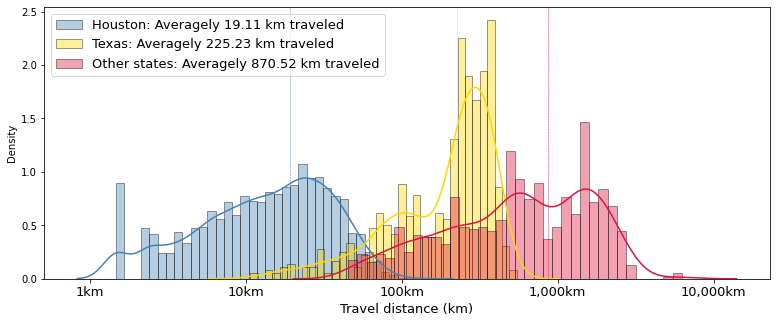

In [25]:
plt.figure(figsize=(13,5))
sns.distplot(np.log10(data['distance'][data['loc_d']==1]), hist=True, kde=True, 
             bins=int(180/5), color = 'steelBlue',
             hist_kws={'edgecolor':'black'}, 
             label = 'Houston: Averagely %0.2f km traveled'%(data['distance'][data['loc_d']==1].mean()))
sns.distplot(np.log10(data['distance'][data['loc_d']==2]), hist=True, kde=True, 
             bins=int(180/5), color = 'gold',
             hist_kws={'edgecolor':'black'},
             label = 'Texas: Averagely %0.2f km traveled'%(data['distance'][data['loc_d']==2].mean()))
sns.distplot(np.log10(data['distance'][data['loc_d']==3]), hist=True, kde=True, 
             bins=int(180/5), color = 'crimson',
             hist_kws={'edgecolor':'black'},
             label = 'Other states: Averagely %0.2f km traveled'%(data['distance'][data['loc_d']==3].mean()))
plt.axvline(np.log10(data['distance'][data['loc_d']==1].mean()),linestyle='--', color='steelblue', linewidth=0.5)
plt.axvline(np.log10(data['distance'][data['loc_d']==2].mean()),linestyle='--', color='gold', linewidth=0.5)
plt.axvline(np.log10(data['distance'][data['loc_d']==3].mean()),linestyle='--', color='crimson', linewidth=0.5)

plt.xticks(range(5), ['1km', '10km', '100km', '1,000km', '10,000km'], fontsize=13)
plt.xlabel('Travel distance (km)',fontsize=13)
plt.legend(fontsize=13)
# plt.savefig('../../figures/FigS5_b.svg', dpi=300, format='svg')

# 4. Contextualize demographic and socioeconomic characteristics

In [26]:
nodes = pd.read_csv('../../outputs/node.csv')
edges = pd.read_csv('../../outputs/edge.csv')
nodes_result = pd.read_csv('../../outputs/node_result.csv')

In [27]:
# User level origin-destination 
df = pd.read_csv('../../outputs/user_origin_destination.csv')
df.head()

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0
2,B435E8D0-941E-45A1-B6C4-55DB9E64B2E9,-95.57,29.92,-95.57,29.92,-95.57,29.92,0,0
3,3C63E77B-7877-4BD2-B59C-4050EE721898,-95.43,29.56,-95.43,29.56,-95.43,29.56,0,0
4,967ECA39-C9A6-43F2-80AB-79F87188F94D,-95.49,29.93,-95.38,30.03,-95.49,29.93,0,1


In [28]:
# Number of users staying within Houston, left to Texas, and out of Texas
df_group = df[['id', 'loc_o', 'loc_d']].groupby(['loc_o', 'loc_d']).count().reset_index()
df_group

,loc_o,loc_d,id
0,0,-1,3423
1,0,0,42277
2,0,1,3624
3,0,2,756
4,0,3,940


In [29]:
# create 'grid_cell' of a given user's origin (their home)
df['cell_id'] = df['x_o'].astype(str)+','+df['y_o'].astype(str)
df.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d,cell_id
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3,"-95.21,29.97"
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0,"-95.39,30.05"


In [30]:
grid_ct = pd.read_csv('../../outputs/clustering_result_grid_level_CT_joined_HarrisCounty.csv')
grid_ct.rename(columns = {'FP':'GEOID_Data'}, inplace = True) 
grid_ct = grid_ct[['cell_id', 'auc_2', 'x', 'y', 'GEOID_Data']]
grid_ct.head(2)

,cell_id,auc_2,x,y,GEOID_Data
0,"-95.72,29.83",8.180484,-95.72,29.83,14000US48201542301
1,"-95.73,29.81",3.151209,-95.73,29.81,14000US48201542301


### Join user level data with census tract id (for demographic comparison)

    Only Harris county is avaialble for 'GEOID_Data'



In [31]:
# print (len(df))
df = pd.merge(df, grid_ct, how='left', on='cell_id')
# print (len(df))
df.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d,cell_id,auc_2,x,y,GEOID_Data
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3,"-95.21,29.97",3.901336,-95.21,29.97,14000US48201250302
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0,"-95.39,30.05",-0.602500,-95.39,30.05,14000US48201241200


### CT level demographic and socioeconomic data

In [32]:
ch = pd.read_csv('../../data/independent_variables.csv')

ch['med_building_age'] = ch['med_building_age'].replace(np.nan, ch['med_building_age'].mean())
ch['pct_hh_computer']  = ch['pct_hh_computer'].replace(np.nan, ch['pct_hh_computer'].mean())
ch['pct_lim_Eng'] = ch['pct_lim_Eng'].replace(np.nan, 0)
ch['pct_lim_Eng_Spanish'] = ch['pct_lim_Eng_Spanish'].replace(np.nan, 0)
ch['pct_lim_Eng_Euro'] = ch['pct_lim_Eng_Euro'].replace(np.nan, 0)
ch['pct_lim_Eng_Asian'] = ch['pct_lim_Eng_Asian'].replace(np.nan, 0)
ch['pct_hh_food_stamp'] = ch['pct_hh_food_stamp'].replace(np.nan, 0)
ch['gini_coeff'] = ch['gini_coeff'].replace(np.nan, ch['gini_coeff'].mean())
ch['pct_hh_kids_6'] = ch['pct_hh_kids_6'].replace(np.nan, 0)
ch['pct_hh_kids_6_18'] = ch['pct_hh_kids_6_18'].replace(np.nan, 0)

col_list = ['pct_hh_alone', 'pct_hu_mobile', 'pct_hh_no_internet']
for c in col_list:
    ch[c] = ch[c].replace(np.nan, 0)
    
col_list = ['avg_hh_size', 'pct_hu_owned', 'pct_hh_income_lt_25k', 'pct_hh_income_25_75k', 'pct_hh_income_gt_75k',
            'med_income', 'pct_hh_poverty', 'med_room', 'pct_pop_unemp', 'pct_hu_vacant', 'pct_hh_vehicle']

for c in col_list:
    ch[c] = ch[c].replace(np.nan, ch[c].mean())
    
ch['cat_evacuation'][ch['cat_evacuation'].notnull()] = 1
ch['cat_evacuation'][ch['cat_evacuation'].isnull()] = 0

col_list = ['pct_pop_age_lt_18', 'pct_pop_age_18_30', 'pct_pop_age_gt_65', 'med_building_age', 'pct_hh_computer', 
            'pct_pop_disability', 'pct_high_edu', 'pct_low_edu', 'pct_lim_Eng', 'pct_lim_Eng_Spanish', 
            'pct_lim_Eng_Euro', 'pct_lim_Eng_Asian', 'pct_white', 'pct_black', 'pct_asian', 'pct_other', 
            'hhi_race', 'pct_hh_food_stamp', 'pct_foreign', 'gini_coeff', 'pct_no_health_insu', 'pct_hh_kids_6',
            'pct_hh_kids_6_18', 'pct_hh_alone', 'avg_hh_size', 'pct_hispanic', 'pct_hu_owned', 'pct_hu_mobile', 
            'pct_hh_income_lt_25k', 'pct_hh_income_25_75k', 'pct_hh_income_gt_75k', 'med_income',
            'pct_hh_no_internet', 'pct_hh_poverty', 'med_room', 'pct_pop_unemp', 'pct_hu_vacant', 
            'pct_hh_vehicle', 'pct_pop_veteran', 'pop_den', 'pct_open_space', 'pct_single_housing', 
            'pct_multi_housing', 'pct_commercial', 'pct_industrial', 'pct_lower', 'pct_flood', 'pct_surge', 
            'cat_evacuation', 'dist_shelter', 'prox_road']

ch.head()

,Unnamed: 0,GEOID_Data,pct_pop_age_lt_18,pct_pop_age_18_30,pct_pop_age_gt_65,med_building_age,pct_hh_computer,pct_pop_disability,pct_high_edu,pct_low_edu,...,pct_single_housing,pct_multi_housing,pct_commercial,pct_industrial,pct_lower,pct_flood,pct_surge,cat_evacuation,dist_shelter,prox_road
0,0,14000US48201100000,0.020374,0.210314,0.062818,52.0,0.955337,0.129,0.265,0.211,...,0.429126,0.024213,0.288041,0.002492,0.129450,0.214511,0.0,0,858.749362,941.338876
1,1,14000US48201210100,0.016475,0.437460,0.008477,40.0,1.000000,0.229,0.014,0.415,...,0.042335,0.018153,0.248999,0.000000,0.327097,0.448101,0.0,0,1535.535316,288.993681
2,2,14000US48201210400,0.297849,0.165716,0.141352,72.0,0.609074,0.141,0.014,0.250,...,0.346293,0.039104,0.134748,0.006044,0.352467,0.218410,0.0,0,1237.472764,727.831989
3,3,14000US48201210500,0.279518,0.197734,0.094884,62.0,0.771769,0.147,0.036,0.207,...,0.470954,0.049581,0.182021,0.000000,0.059127,0.062049,0.0,0,1062.784712,1212.852991
4,4,14000US48201210600,0.238419,0.165060,0.104368,69.0,0.939647,0.121,0.093,0.274,...,0.756428,0.019605,0.097767,0.000000,0.000000,0.031548,0.0,0,517.789137,773.746959


### Join user level data + demographic

In [33]:
df = pd.merge(df, ch, how='left', on='GEOID_Data')
# print (len(df))
df.head(2)

,id,x_o,y_o,x_d,y_d,x_home,y_home,loc_o,loc_d,cell_id,...,pct_single_housing,pct_multi_housing,pct_commercial,pct_industrial,pct_lower,pct_flood,pct_surge,cat_evacuation,dist_shelter,prox_road
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,-90.00,35.00,-95.21,29.97,0,3,"-95.21,29.97",...,0.750882,0.014853,0.048287,0.0,0.000000,0.040746,0.000000,0,3711.919756,3527.522448
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,-95.39,30.05,-95.39,30.05,0,0,"-95.39,30.05",...,0.522446,0.042573,0.042034,0.0,0.089511,0.252733,0.000164,0,3664.219687,783.490999


In [34]:
df[['id','x_o','y_o', 'loc_d','cell_id','auc_2', 'GEOID_Data']+col_list].head(2)

,id,x_o,y_o,loc_d,cell_id,auc_2,GEOID_Data,pct_pop_age_lt_18,pct_pop_age_18_30,pct_pop_age_gt_65,...,pct_single_housing,pct_multi_housing,pct_commercial,pct_industrial,pct_lower,pct_flood,pct_surge,cat_evacuation,dist_shelter,prox_road
0,0B4899A7-3BE8-4AA7-BE67-3FD2054F8B02,-95.21,29.97,3,"-95.21,29.97",3.901336,14000US48201250302,0.300817,0.151407,0.068798,...,0.750882,0.014853,0.048287,0.0,0.000000,0.040746,0.000000,0,3711.919756,3527.522448
1,8F1826F3-D253-451F-A238-657AFBB98819,-95.39,30.05,0,"-95.39,30.05",-0.602500,14000US48201241200,0.333975,0.156130,0.078752,...,0.522446,0.042573,0.042034,0.0,0.089511,0.252733,0.000164,0,3664.219687,783.490999


In [35]:
df_harris = df[df['GEOID_Data'].notnull()]
# print (len(df_harris))

### Demographic/socioeconomic characteristics of each group based on relocation patterns during Harvey

    1: within Houston
    2: within Texas
    3: to other states



In [36]:
mean_std_list_total = []
for col in col_list:
    mean_std_list = []
    for i in [1,2,3]:
        mean = df_harris[col][df_harris['loc_d']==i].mean()
        std = df_harris[col][df_harris['loc_d']==i].std()
        mean_std = round(mean,4), round(std,4)
        mean_std_list.append(mean_std)
    mean_std_list_total.append(mean_std_list)

In [37]:
df_summary = pd.DataFrame(mean_std_list_total)
df_summary['feature'] = col_list
df_summary.columns = ['Houston', 'Texas', 'US', 'feature']
df_summary = df_summary[['feature', 'Houston', 'Texas', 'US']]

for c in ['Houston', 'Texas', 'US']:
    df_summary[c] = df_summary[c].astype(str).str.replace('(','')
    df_summary[c] = df_summary[c].astype(str).str.replace(', ',' (')    

In [38]:
df_summary

,feature,Houston,Texas,US
0,pct_pop_age_lt_18,0.2531 (0.0784),0.2546 (0.069),0.247 (0.0804)
1,pct_pop_age_18_30,0.1767 (0.0859),0.161 (0.0839),0.1744 (0.086)
2,pct_pop_age_gt_65,0.1054 (0.0547),0.1147 (0.0582),0.1063 (0.0513)
3,med_building_age,33.6797 (14.9879),32.1457 (14.8345),32.8019 (14.493)
4,pct_hh_computer,0.9097 (0.0931),0.9248 (0.0807),0.9213 (0.0785)
5,pct_pop_disability,0.0908 (0.0522),0.0866 (0.0342),0.0888 (0.0495)
6,pct_high_edu,0.1368 (0.121),0.1562 (0.1187),0.1474 (0.1231)
7,pct_low_edu,0.2098 (0.0971),0.1894 (0.0981),0.2024 (0.1036)
8,pct_lim_Eng,0.086 (0.0989),0.0698 (0.0857),0.0745 (0.0852)
9,pct_lim_Eng_Spanish,0.1824 (0.1562),0.1635 (0.1489),0.1654 (0.1461)


In [39]:
scaler = StandardScaler()
df_scal = df_harris[df_harris['loc_d'].isin([1,2,3])]
df_scal['loc_d_copy'] = df_scal['loc_d']


df_scal[col_list] = scaler.fit_transform(df_scal[col_list])
df_scal[['GEOID_Data', 'loc_d_copy']+col_list].head(2)

,GEOID_Data,loc_d_copy,pct_pop_age_lt_18,pct_pop_age_18_30,pct_pop_age_gt_65,med_building_age,pct_hh_computer,pct_pop_disability,pct_high_edu,pct_low_edu,...,pct_single_housing,pct_multi_housing,pct_commercial,pct_industrial,pct_lower,pct_flood,pct_surge,cat_evacuation,dist_shelter,prox_road
0,14000US48201250302,3,0.626825,-0.264665,-0.695514,-1.095876,0.675425,-0.218275,-0.514415,0.165734,...,1.129504,-0.294672,-0.73259,-0.273226,-0.488848,-0.930426,-0.170555,-0.578133,0.682873,1.463230
4,14000US48201533901,1,0.809965,0.107410,-0.271911,0.449407,-0.186426,0.769462,-0.992804,1.463253,...,1.124660,-0.543411,-0.24513,-0.273226,-0.488848,-1.042759,-0.170555,-0.578133,1.498801,-0.521802


In [40]:
df_scal2 = df_scal[['loc_d_copy']+col_list].groupby('loc_d_copy').mean().reset_index()
df_scal2.head()

,loc_d_copy,pct_pop_age_lt_18,pct_pop_age_18_30,pct_pop_age_gt_65,med_building_age,pct_hh_computer,pct_pop_disability,pct_high_edu,pct_low_edu,pct_lim_Eng,...,pct_single_housing,pct_multi_housing,pct_commercial,pct_industrial,pct_lower,pct_flood,pct_surge,cat_evacuation,dist_shelter,prox_road
0,1,0.011198,0.030037,-0.026478,0.024767,-0.046365,0.018613,-0.037872,0.041750,0.045309,...,-0.020512,0.006255,0.008684,0.007865,-0.030611,0.021553,-0.028430,-0.008781,-0.011302,-0.016883
1,2,0.031450,-0.152566,0.144537,-0.078297,0.121904,-0.065244,0.122649,-0.164387,-0.125733,...,0.036579,-0.082158,-0.048011,-0.049646,0.036256,0.013290,0.035671,-0.145717,0.059783,0.081710
2,3,-0.067097,0.003010,-0.010415,-0.034204,0.083090,-0.020760,0.050048,-0.032636,-0.076096,...,0.050161,0.039543,0.003883,0.008279,0.089018,-0.092655,0.081131,0.146115,-0.002968,0.001430


### Create a radar plot

In [41]:
radar_plot_cols = ['cat_evacuation','pct_white', 
                  'pct_hu_owned', 'med_income', 
                   'pct_high_edu','pct_hh_vehicle', 'pct_no_health_insu']

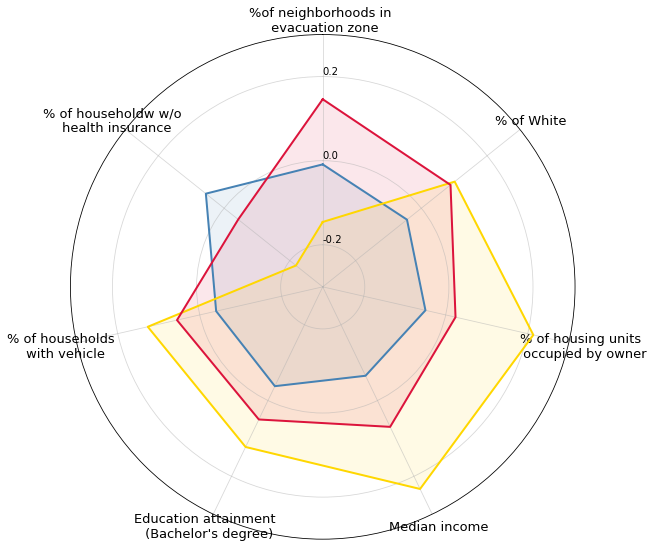

In [44]:
# ------- PART 1: Create background
 
# number of variable
categories=list(df_scal2[radar_plot_cols])
N = len(categories)
 
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]
 
# Initialise the spider plot
fig=plt.figure(figsize=(9,9))
ax = plt.subplot(111, polar=True)
 
# If you want the first axis to be on top:
ax.set_theta_offset(pi / 2)
ax.set_theta_direction(-1)
 
categories_ = ['%of neighborhoods in \n evacuation zone','% of White', 
                  '% of housing units \n occupied by owner', 'Median income', 
                   "Education attainment \n (Bachelor's degree)",'% of households \n with vehicle', 
               '% of householdw w/o \n health insurance',]
plt.xticks(angles[:-1], categories_, color='k', size=13)

# Draw ylabels
ax.set_rlabel_position(0)
plt.yticks([-0.2,0.0,0.2], ["-0.2","0.0","0.2"], color="k", size=10)
plt.ylim(-0.3,0.3)

#PART 2: Add plots
 
# Ind1
values=df_scal2[categories].loc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="wihtin Houston", color='steelBlue')
ax.fill(angles, values, 'b', alpha=0.1, color='steelBlue')
 
# Ind2
values=df_scal2[categories].loc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="to Texas", color='gold')
ax.fill(angles, values, 'r', alpha=0.1, color='gold')

# Ind2
values=df_scal2[categories].loc[2].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=2, linestyle='solid', label="to other states", color='crimson')
ax.fill(angles, values, 'r', alpha=0.1, color='crimson')
 
# Add legend
# plt.legend(loc='upper center', bbox_to_anchor=(2, 1), fontsize=15)

plt.grid(alpha=0.5)
plt.tight_layout()
# plt.savefig('../../figures/FigS5_c.svg', dpi=300, format='svg')
plt.show()